# 2019 Canadian Election tweets
# OSEMN Step 3: Explore
# Explore Sentiment 140 dataset (no duplicates)

This notebook describes part of Step 3: Explore of OSEMN methodology. It covers cleanup of Sentiment 140.

## Import dependencies

In [21]:
random_state = 0

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from time import time

sns.set()

In [3]:
sys.path.append('../../src/')
from proc_utils import string_concat, tfm_2class

In [4]:
data_dir = '../../data/sentiment140/'
os.listdir(data_dir)

['testdata.manual.2009.06.14.csv',
 'training.1600000.processed.noemoticon.csv',
 'sentiment140_train_nodup.csv',
 'sentiment140_train_cleaned.csv']

## Load cleaned Sentiment 140 dataset

In [5]:
t = time()
df = pd.read_csv(data_dir + 'sentiment140_train_nodup.csv')
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:.2f} seconds".format(elapsed) +
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) +
      "\n-- Column names:\n", df.columns)

----- DataFrame loaded
in 6.20 seconds
with 1,309,540 rows
and 8 columns
-- Column names:
 Index(['sentiment', 'ids', 'date', 'query', 'user', 'text', 'hashtags',
       'handles'],
      dtype='object')


## Count of tweets per class

In [6]:
df['sentiment'].value_counts()

0    678182
4    631358
Name: sentiment, dtype: int64

## Word clouds
Word clouds are produced separately for negative and positive tweets

First 500 symbols in the  string:

switchfoot awww that s a bummer you shoulda got david carr of third day to do it d;D is upset that he can t update his facebook by texting it and might cry as a result school today also blah kenichan i dived many times for the ball managed to save 50 the rest go out of bounds my whole body feels itchy and like its on fire kwesidei not the whole crew need a hug tatiana_k nope they didn t have it twittera que me muera spring break in plain city it s snowing i just re pierced my ears caregiving i c


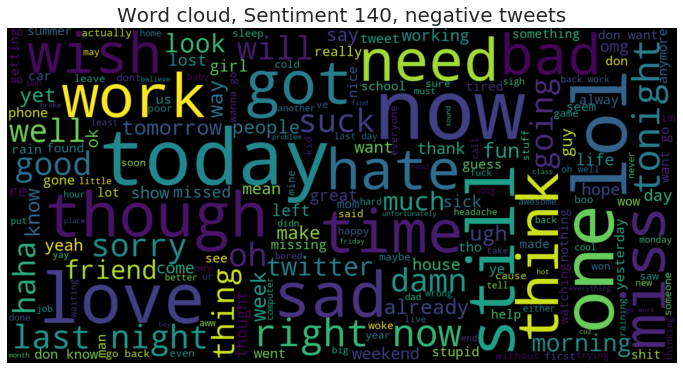

In [8]:
neg_tweets = df[df['sentiment'] == 0]
neg_string = string_concat(neg_tweets['text'])

wordcloud = WordCloud(width=1600, height=800, max_font_size=200, 
                      colormap='viridis').generate(neg_string)

f, ax = plt.subplots(1, figsize=(12,10))
ax.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
ax.set_title("Word cloud, Sentiment 140, negative tweets", fontsize=20)
f.savefig('results/wordcloud_sentiment140_nodup_neg.png')

First 500 symbols in the  string:

i love health4uandpets u guys r the best im meeting up with one of my besties tonight cant wait girl talk darealsunisakim thanks for the twitter add sunisa i got to meet you once at a hin show here in the dc area and you were a sweetheart being sick can be really cheap when it hurts too much to eat real food plus your friends make you soup lovesbrooklyn2 he has that effect on everyone productoffear you can tell him that i just burst out laughing really loud because of that thanks for making me c


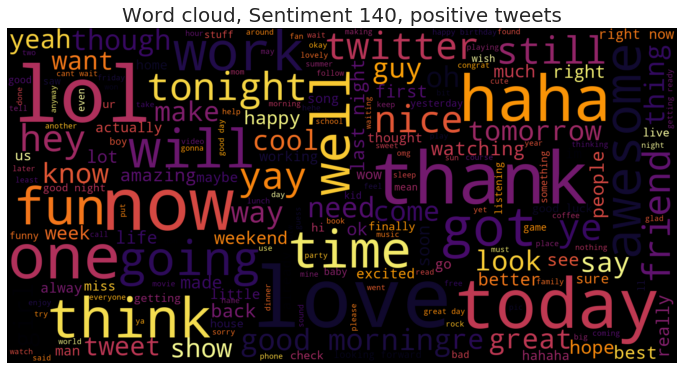

In [9]:
pos_tweets = df[df['sentiment'] == 4]
pos_string = string_concat(pos_tweets['text'])

wordcloud = WordCloud(width=1600, height=800, max_font_size=200, 
                      colormap='inferno').generate(pos_string)

f, ax = plt.subplots(1, figsize=(12,10))
ax.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
ax.set_title("Word cloud, Sentiment 140, positive tweets", fontsize=20)
f.savefig('results/wordcloud_sentiment140_nodup_pos.png')

## Most frequent hashtags

In [10]:
# concatenate hashtags from all tweets together, convert to lower case, split by ' ', save to a pandas Series 
all_hashtags_se = pd.Series(df['hashtags'].str.cat(sep=" ").lower().split())

print("Top 10 hashtags by frequency:\n")
print(all_hashtags_se.value_counts().head(10))

Top 10 hashtags by frequency:

#fb              1650
#followfriday    1649
#squarespace      871
#ff               609
#iranelection     445
#1                409
#musicmonday      315
#bsb              287
#asot400          282
#2                280
dtype: int64


## Most frequent user handles

In [11]:
# concatenate hashtags from all tweets together, convert to lower case, split by ' ', save to a pandas Series 
all_handles_se = pd.Series(df['handles'].str.cat(sep=" ").lower().split())

print("Top 10 user handles by frequency:\n")
print(all_handles_se.value_counts().head(10))

Top 10 user handles by frequency:

@mileycyrus         3678
@ddlovato           2680
@tommcfly           2638
@jonasbrothers      1884
@davidarchie         970
@donniewahlberg      930
@taylorswift13       857
@mitchelmusso        801
@jonathanrknight     702
@jordanknight        696
dtype: int64


## Length of tweets

In [12]:
t = time()
# add a new column with length of strings in 'text' to the DataFrame with generic tweets
df['text_len'] = df['text'].str.len()
elapsed = time() - t
print("Column 'text_len' was added to the DataFrame. Took {0:,.2f} seconds ({1:,.2f} minutes)"
      .format(elapsed, elapsed / 60))

Column 'text_len' was added to the DataFrame. Took 0.98 seconds (0.02 minutes)


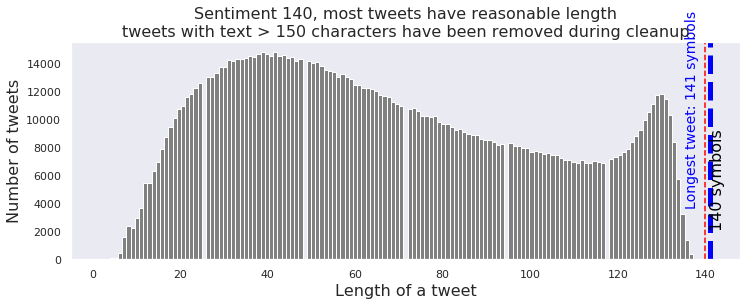

In [13]:
# plot histogram of values
# create figure and axis
f, ax = plt.subplots(1, figsize=(12, 4))

# plot a histogram of 'text_len'
df['text_len'].hist(bins=145, color='gray')

# draw supplementary lines -- 140 symbols, longest tweet in the dataset
font = {'size': 16}
ax.axvline(140, color='red', linestyle='--', )
ax.text(141, 
        2300, 
        "140 symbols", 
        rotation=90, 
        color='black', 
        fontdict=font)

ax.axvline(df['text_len'].max(), color='blue', linestyle='--', linewidth=5)
ax.text(df['text_len'].max() * 0.96, 
        3900, 
        "Longest tweet: {0} symbols".format(df['text_len'].max()), 
        rotation=90, 
        color='blue', 
        fontdict={'size': 14})

# set axis parameters
ax.set_title("Sentiment 140, most tweets have reasonable length"
             "\ntweets with text > 150 characters have been removed during cleanup", 
             fontdict=font)
ax.set_xlabel("Length of a tweet", fontdict=font)
ax.set_ylabel("Number of tweets", fontdict=font)
ax.grid(False)
f.savefig('results/textlen_sentiment140_nodup.png', bbox_inches='tight')

## Term Frequency Matrix

### Document frequency limits: min=0.0, max=0.9

In [14]:
min_df = 0.0
max_df = 0.9

tfm = tfm_2class(df, 'sentiment', 
                 [0, 4], 'text', 
                 min_df=min_df, max_df=max_df)

print("Number of tokens in vocabulary")
print("when using 'min_df'={0} and 'max_df'={1}:"
      .format(min_df, max_df))
print(len(tfm))

tfm.sort_values('abs_diff', ascending=False)

Number of tokens in vocabulary
when using 'min_df'=0.0 and 'max_df'=0.9:
553509


,neg_tf,pos_tf,total,abs_diff
love,16974,43339,60313,26365
work,40770,16415,57185,24355
good,24101,47524,71625,23423
sad,24268,1143,25411,23125
miss,26911,4639,31550,22272
...,...,...,...,...
simce,1,1,2,0
barcardi,1,1,2,0
tweet__me_right,1,1,2,0
montezuma,1,1,2,0


### Document frequency limits: min=0.01, max=0.9

In [15]:
min_df = 0.01
max_df = 0.9

tfm = tfm_2class(df, 'sentiment', 
                 [0, 4], 'text', 
                 min_df=min_df, max_df=max_df)

print("Number of tokens in vocabulary")
print("when using 'min_df'={0} and 'max_df'={1}:"
      .format(min_df, max_df))
print(len(tfm))

tfm.sort_values('abs_diff', ascending=False)

Number of tokens in vocabulary
when using 'min_df'=0.01 and 'max_df'=0.9:
74


,neg_tf,pos_tf,total,abs_diff
love,16974,43339,60313,26365
work,40770,16415,57185,24355
good,24101,47524,71625,23423
sad,24268,1143,25411,23125
miss,26911,4639,31550,22272
...,...,...,...,...
little,7251,6914,14165,337
people,8472,8145,16617,327
soon,7087,7370,14457,283
weekend,8054,8321,16375,267


### Document frequency limits: min=0.03, max=0.9

In [16]:
min_df = 0.03
max_df = 0.9

tfm = tfm_2class(df, 'sentiment', 
                 [0, 4], 'text', 
                 min_df=min_df, max_df=max_df)

print("Number of tokens in vocabulary")
print("when using 'min_df'={0} and 'max_df'={1}:"
      .format(min_df, max_df))
print(len(tfm))

tfm.sort_values('abs_diff', ascending=False)


Number of tokens in vocabulary
when using 'min_df'=0.03 and 'max_df'=0.9:
10


,neg_tf,pos_tf,total,abs_diff
love,16974,43339,60313,26365
work,40770,16415,57185,24355
good,24101,47524,71625,23423
today,33680,25208,58888,8472
got,28388,22924,51312,5464
like,33575,28491,62066,5084
just,53971,50275,104246,3696
going,29168,25796,54964,3372
day,35601,38158,73759,2557
time,23544,24445,47989,901


## Latent Dirichlet Allocation

### Negative tweets

In [34]:
s_pos = df.query('sentiment == 0')
len(s_pos)

678182

In [35]:
t = time()
bow_pos = CountVectorizer(stop_words='english', max_df=0.1, max_features=5000)
tweets_bow_pos = bow_pos.fit_transform(s_pos['text'])
elapsed = time() - t
print("Bag of words created. Took {0:,.2f} seconds ({1:,.2f} minutes).".format(elapsed, elapsed / 60))

Bag of words created. Took 12.85 seconds (0.21 minutes).


In [36]:
tweets_bow_pos

<678182x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 3641280 stored elements in Compressed Sparse Row format>

### 10 topics

In [38]:
t = time()
lda_pos = LatentDirichletAllocation(random_state=random_state, verbose=1,
                                    n_components=10, learning_method='batch')
tweets_topics_pos = lda_pos.fit_transform(tweets_bow_pos)
elapsed = time() - t
print("LDA finished. Took {0:,.2f} seconds ({1:,.2f} minutes).".format(elapsed, elapsed / 60))

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
LDA finished. Took 3,157.85 seconds (52.63 minutes).


In [39]:
lda_pos.components_.shape

(10, 5000)

In [40]:
n_top_words = 5
feature_names_pos = bow_pos.get_feature_names()
for topic_idx, topic in enumerate(lda_pos.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names_pos[i]
                    for i in topic.argsort()\
                    [:-n_top_words - 1:-1]]))

Topic 1:
day work today wish tired
Topic 2:
miss just night love missed
Topic 3:
tomorrow school time going work
Topic 4:
got ve just won hurts
Topic 5:
twitter just did think like
Topic 6:
don want feel like know
Topic 7:
wish really just left ll
Topic 8:
sorry new working hard iphone
Topic 9:
man like poor watching just
Topic 10:
im sad lol come missing


### 5 topics

In [47]:
t = time()
lda_pos = LatentDirichletAllocation(random_state=random_state, verbose=1,
                                    n_components=5, learning_method='batch')
tweets_topics_pos = lda_pos.fit_transform(tweets_bow_pos)
elapsed = time() - t
print("LDA finished. Took {0:,.2f} seconds ({1:,.2f} minutes).".format(elapsed, elapsed / 60))

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
LDA finished. Took 3,687.56 seconds (61.46 minutes).


In [48]:
lda_pos.components_.shape

(5, 5000)

In [49]:
n_top_words = 5
feature_names_pos = bow_pos.get_feature_names()
for topic_idx, topic in enumerate(lda_pos.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names_pos[i]
                    for i in topic.argsort()\
                    [:-n_top_words - 1:-1]]))

Topic 1:
work day today im going
Topic 2:
miss just love sorry oh
Topic 3:
need time work sucks life
Topic 4:
got just ve day won
Topic 5:
like don think know feel


### Positive tweets

In [41]:
s_neg = df.query('sentiment == 4')
len(s_neg)

631358

In [42]:
t = time()
bow_neg = CountVectorizer(stop_words='english', max_df=0.1, max_features=5000)
tweets_bow_neg = bow_neg.fit_transform(s_neg['text'])
elapsed = time() - t
print("Bag of words created. Took {0:,.2f} seconds ({1:,.2f} minutes).".format(elapsed, elapsed / 60))

Bag of words created. Took 12.37 seconds (0.21 minutes).


In [43]:
tweets_bow_neg

<631358x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 3220497 stored elements in Compressed Sparse Row format>

### 10 topics

In [44]:
t = time()
lda_neg = LatentDirichletAllocation(random_state=random_state, verbose=1,
                                    n_components=10, learning_method='batch')
tweets_topics_neg = lda_neg.fit_transform(tweets_bow_neg)
elapsed = time() - t
print("LDA finished. Took {0:,.2f} seconds ({1:,.2f} minutes).".format(elapsed, elapsed / 60))

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
LDA finished. Took 2,804.40 seconds (46.74 minutes).


In [45]:
lda_neg.components_.shape

(10, 5000)

In [46]:
n_top_words = 5
feature_names_neg = bow_neg.get_feature_names()
for topic_idx, topic in enumerate(lda_neg.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names_neg[i]
                    for i in topic.argsort()\
                    [:-n_top_words - 1:-1]]))

Topic 1:
just getting work ready got
Topic 2:
know happy way let birthday
Topic 3:
day thank right happy song
Topic 4:
new look looking follow sweet
Topic 5:
just ll ve people twitter
Topic 6:
thanks nice today yeah day
Topic 7:
lol im want glad haha
Topic 8:
love like awesome fun welcome
Topic 9:
going time home tomorrow bed
Topic 10:
good morning night hey hope


### 5 topics

In [50]:
t = time()
lda_neg = LatentDirichletAllocation(random_state=random_state, verbose=1,
                                    n_components=5, learning_method='batch')
tweets_topics_neg = lda_neg.fit_transform(tweets_bow_neg)
elapsed = time() - t
print("LDA finished. Took {0:,.2f} seconds ({1:,.2f} minutes).".format(elapsed, elapsed / 60))

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
LDA finished. Took 3,253.60 seconds (54.23 minutes).


In [51]:
lda_neg.components_.shape

(5, 5000)

In [52]:
n_top_words = 5
feature_names_neg = bow_neg.get_feature_names()
for topic_idx, topic in enumerate(lda_neg.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names_neg[i]
                    for i in topic.argsort()\
                    [:-n_top_words - 1:-1]]))

Topic 1:
going night just home time
Topic 2:
thanks know lol love don
Topic 3:
day love good morning great
Topic 4:
new like good come watching
Topic 5:
just ll ve twitter got
